In [21]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import torch
import xgboost as xgb

In [1]:
!pip install xgboost


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: C:\Users\ccana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     --------------------------------------- 89.1/89.1 MB 25.2 MB/s eta 0:00:00


Open data obtain from roboflow (csv tensorflow)

In [2]:
test=pd.read_csv('KITAI_Dataset_1/test/_annotations.csv')
train=pd.read_csv('KITAI_Dataset_1/train/_annotations.csv')
valid=pd.read_csv('KITAI_Dataset_1/valid/_annotations.csv')

test.head()

Create image and resizing bacteria (to have equal size of matrix). The image must be flatten and converted into list to have correct dimensions for model

In [3]:
def crop_image (image_path, xmin, xmax, ymin, ymax):
        im=cv.imread(image_path)
        crop_img=im[ymin:ymax, xmin:xmax]
        resize= cv.resize(crop_img, (10,10),interpolation=cv.INTER_AREA).flatten()
        return resize.tolist()

Obtaining X and Y data for model. This model will be cyanobacteria (0) - not cyanobacteria (1)

In [5]:
X_test=[]
Y_test=[]
for index,row in test.iterrows():
    X_test.append(crop_image('KITAI_Dataset_1/test/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
    if row['class']=='cyanobacteria':
        Y_test.append(0)
    else:
        Y_test.append(1)

    

Same for train and validation data

In [6]:
X_train=[]
Y_train=[]
for index,row in train.iterrows():
    try:
        X_train.append(crop_image('KITAI_Dataset_1/train/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
        if row['class']=='cyanobacteria':
            Y_train.append(0)
        else:
            Y_train.append(1)
    except:
        pass

In [7]:
X_valid=[]
Y_valid=[]
for index,row in valid.iterrows():
    try:
        X_valid.append(crop_image('KITAI_Dataset_1/valid/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
        if row['class']=='cyanobacteria':
            Y_valid.append(0)
        else:
            Y_valid.append(1)
    except:
        pass

List are converted into numpy arrays

In [8]:
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)

What we are here: Use kNN to predict cyanobacteria (without data augmentation), k between 1 and 50

In [9]:
range_k = range(1,60)
scores = {}
scores_list = []
for k in range_k:   
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    scores[k] = metrics.accuracy_score(Y_test,y_pred)
    scores_list.append(metrics.accuracy_score(Y_test,y_pred))

Plot to see k with best acurracy

Text(0, 0.5, 'Accuracy')

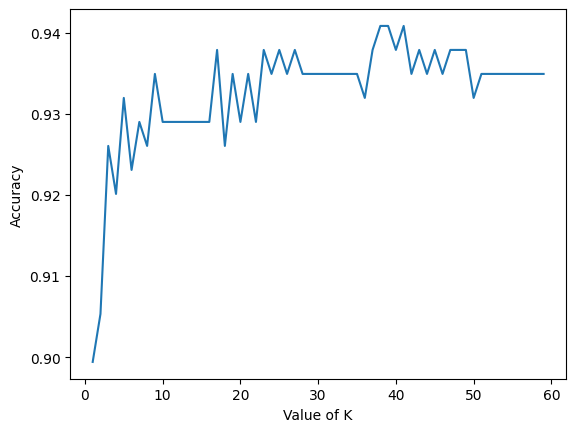

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range_k,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

As k=16 has best acurracy

In [11]:
classifier = KNeighborsClassifier(n_neighbors = 16)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)

**Testing**

Confunsion matrix and Classification report is calculated

In [12]:
result = metrics.confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(Y_test, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[141   2]
 [ 22 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       143
           1       0.99      0.89      0.94       195

    accuracy                           0.93       338
   macro avg       0.93      0.94      0.93       338
weighted avg       0.94      0.93      0.93       338



In [13]:
print("RMSE DT:",np.sqrt(mean_squared_error(Y_test, y_pred)))
print("R2 DT:",r2_score(Y_test, y_pred))
predictions = np.mean(cross_validate(classifier,X_test,Y_test,cv=100)['test_score'])
print('The accuracy is (cross validation*100): ',predictions*100,'%')

RMSE DT: 0.2664693550105965
R2 DT: 0.7090909090909091
The accuracy is (cross validation*100):  93.08333333333334 %


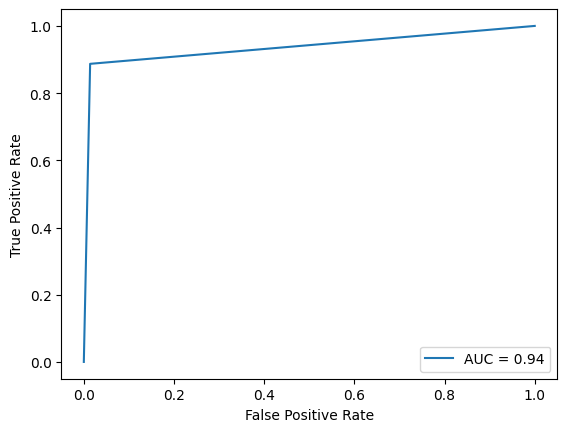

In [14]:
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
roc_pls.plot()
plt.show()

In [15]:
y_valid=classifier.predict(X_valid)

In [16]:
result = metrics.confusion_matrix(Y_valid, y_valid)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(Y_valid, y_valid)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[233   9]
 [ 37 334]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       242
           1       0.97      0.90      0.94       371

    accuracy                           0.92       613
   macro avg       0.92      0.93      0.92       613
weighted avg       0.93      0.92      0.93       613



In [17]:
print("RMSE DT:",np.sqrt(mean_squared_error(Y_valid, y_valid)))
print("R2 DT:",r2_score(Y_valid, y_valid))
predictions = np.mean(cross_validate(classifier,X_valid,Y_valid,cv=100)['test_score'])
print('Cross Validation:', predictions)
print('The accuracy is: ',predictions*100,'%')

RMSE DT: 0.2739357279258362
R2 DT: 0.6859281370430599
Cross Validation: 0.9130952380952381
The accuracy is:  91.30952380952381 %


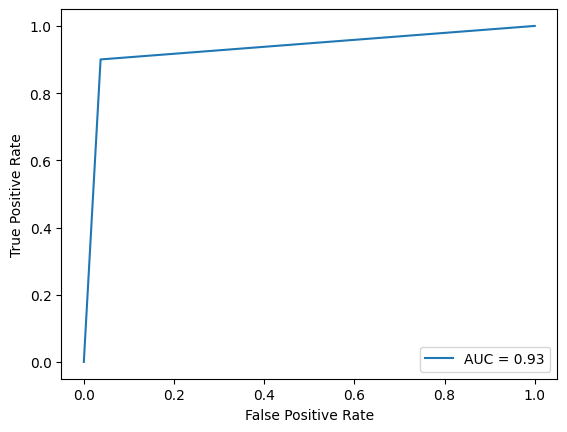

In [18]:
fpr, tpr, _ = roc_curve(Y_valid, y_valid)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
roc_pls.plot()
plt.show()

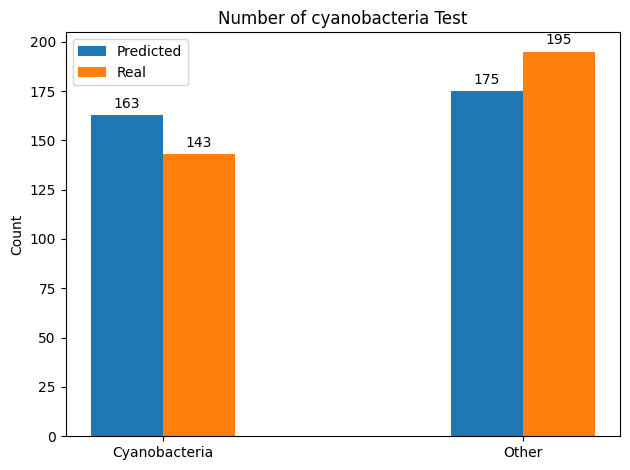

In [19]:
y_pred_list= y_pred.tolist()
Y_test_list=Y_test.tolist()

labels = ['Cyanobacteria', 'Other']
predicted = [y_pred_list.count(0),y_pred_list.count(1)]
real=[Y_test_list.count(0),Y_test_list.count(1)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted, width, label='Predicted')
rects2 = ax.bar(x + width/2, real, width, label='Real')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Number of cyanobacteria Test')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

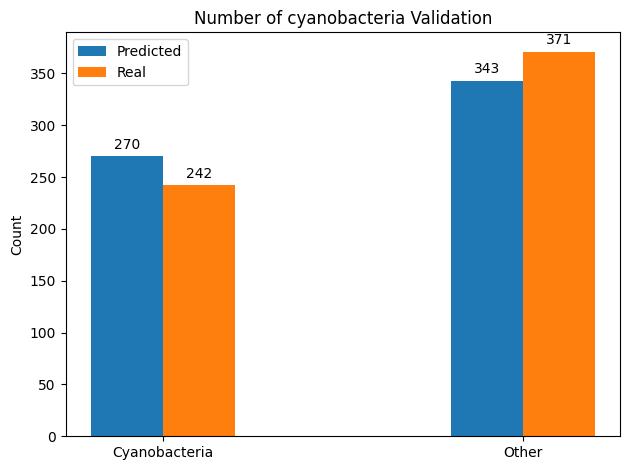

In [20]:
y_valid_list= y_valid.tolist()
Y_valid_list=Y_valid.tolist()

labels = ['Cyanobacteria', 'Other']
predicted_v = [y_valid_list.count(0),y_valid_list.count(1)]
real_v=[Y_valid_list.count(0),Y_valid_list.count(1)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted_v, width, label='Predicted')
rects2 = ax.bar(x + width/2, real_v, width, label='Real')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Number of cyanobacteria Validation')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()